# Dog Breed Detection using ResNet50


## Importing the Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix


## Importing the Data

In [2]:
data_dir = 'dataset/images/Images' 

# Parameters
img_size = 224
batch_size = 32

# Data generators
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 16508 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


## Data Visualization


In [3]:
# One batch of images and labels
x_batch, y_batch = next(train_generator)

print(f"Image batch shape: {x_batch.shape}")   # (batch_size, 224, 224, 3)
print(f"Label batch shape: {y_batch.shape}")   # (batch_size, num_classes)



Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 120)


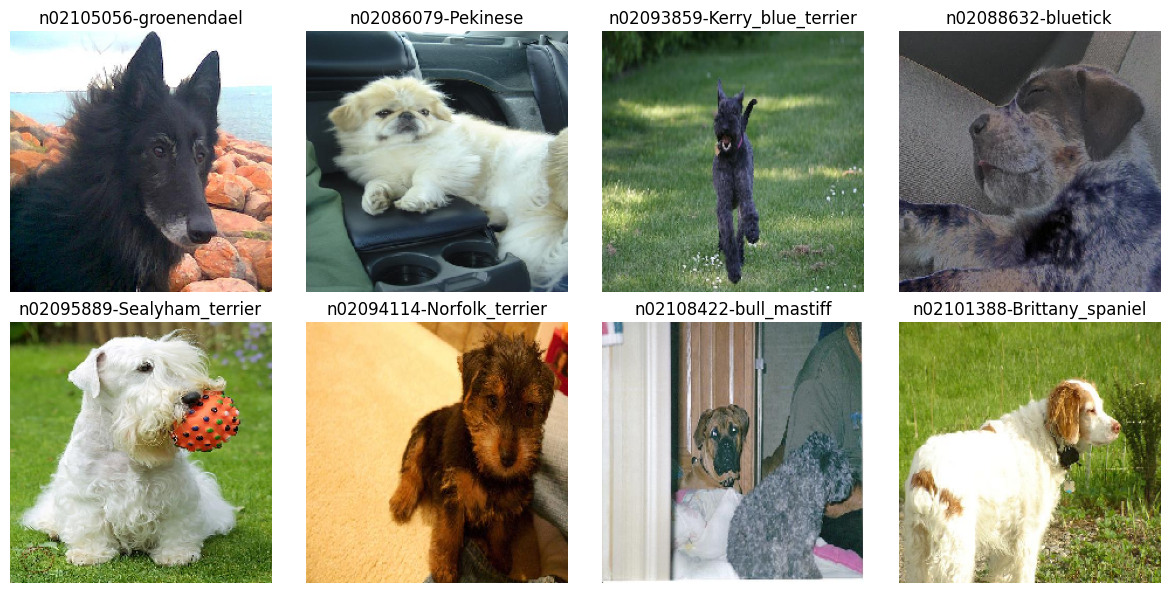

In [5]:
def undo_preprocess_input(img):
    # MobileNetV2 scales inputs to [-1, 1]
    # To revert it, just scale it back to [0, 1]
    img = (img + 1.0) / 2.0
    img = np.clip(img, 0, 1)
    return img
label_map = {v: k for k, v in train_generator.class_indices.items()}

plt.figure(figsize=(12, 6))
for i in range(8):
    ax = plt.subplot(2, 4, i + 1)
    img = undo_preprocess_input(x_batch[i])
    plt.imshow(img)
    plt.title(label_map[np.argmax(y_batch[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


## Model Creation using ResNet50

In [6]:
# Load MobileNetV2 base model
base_model = MobileNetV2(
    input_shape=(img_size, img_size, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │          30,840 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,616,760 (9.98 MB)

 Trainable params: 358,776 (1.37 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Model training

In [7]:
# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

C:\Users\Zubair\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 528s 1s/step - accuracy: 0.4549 - loss: 2.3493 - val_accuracy: 0.7682 - val_loss: 0.7242
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 471s 914ms/step - accuracy: 0.7783 - loss: 0.7033 - val_accuracy: 0.7895 - val_loss: 0.6794
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 465s 902ms/step - accuracy: 0.8313 - loss: 0.5259 - val_accuracy: 0.8008 - val_loss: 0.6563
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 497s 964ms/step - accuracy: 0.8597 - loss: 0.4264 - val_accuracy: 0.7947 - val_loss: 0.6634
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 470s 911ms/step - accuracy: 0.8852 - loss: 0.3378 - val_accuracy: 0.7881 - val_loss: 0.6947
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 459s 889ms/step - accuracy: 0.9044 - loss: 0.2850 - val_accuracy: 0.7937 - val_loss: 0.6988
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 410s 795ms/step - accuracy: 0.9107 - loss: 0.2496 - val_accuracy: 0.7922 - val_loss: 0.7360
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 408s 791ms/step - accuracy: 0.9261 - lo

## Plotting Loss and Accuracy



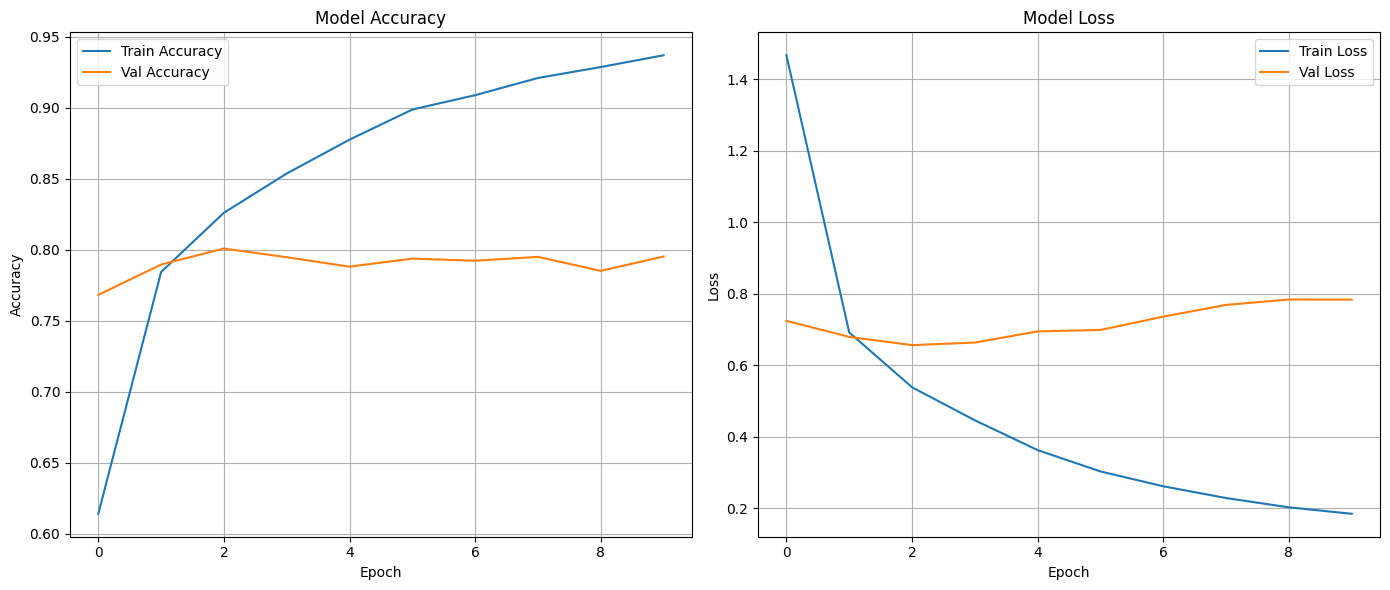

In [9]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
